In [21]:
    # from google.colab import drive
# drive.mount('/content/drive')

In [22]:
# !pip install category_encoders

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go
import category_encoders as ce

from sklearn.preprocessing import OrdinalEncoder, LabelEncoder

from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import CalibratedClassifierCV

from sklearn.metrics import make_scorer, roc_curve, f1_score, roc_auc_score, accuracy_score, classification_report, confusion_matrix, balanced_accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay, precision_recall_curve
from sklearn.svm import LinearSVC, SVC
import warnings
warnings.filterwarnings('ignore')

In [24]:
df = pd.read_csv("./dataset/Stockout/data.zip", compression="zip")
train, test = train_test_split(df, train_size=0.7, stratify=df['went_on_backorder'])
y_train = train.pop('went_on_backorder')
y_test = test.pop('went_on_backorder')

In [25]:
cat_cols = train.select_dtypes(include=['object']).columns.tolist()
# categorical imputer
for cat_col in cat_cols:
    train[cat_col].fillna("__MISS__", inplace=True)
    test[cat_col].fillna("__MISS__", inplace=True)
# ordinal encoder
oe = OrdinalEncoder()
train[cat_cols] = oe.fit_transform(train[cat_cols])
test[cat_cols] = oe.transform(test[cat_cols])
# label encoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
# numerical imputer
simple_imputer = SimpleImputer(strategy="median", copy=False)
train = simple_imputer.fit_transform(train)
test = simple_imputer.transform(test)

In [36]:
def print_classification_report(clf, test, y_test):
    yhat_test = clf.predict(test)
    cm = confusion_matrix(y_test, yhat_test)
    print("********************************************************")
    print("Accuracy on Test data ", accuracy_score(y_test, yhat_test))
    print("********************************************************")
    print("Balanced Accuracy on Test data ", balanced_accuracy_score(y_test, yhat_test))
    print("********************************************************")
    print("AUC ROC on Test data ", roc_auc_score(y_test, yhat_test))
    print("********************************************************")
    print(classification_report(y_test, yhat_test))
    print("********************************************************")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    cm = confusion_matrix(y_test, yhat_test)
    ConfusionMatrixDisplay(cm).plot(ax=ax1)
    fpr, tpr, _ = roc_curve(y_test, yhat_test, pos_label=clf.classes_[1])
    RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=ax2)

### Support Vector Machine

In [27]:
scaler = StandardScaler()
train_nn = scaler.fit_transform(train)

In [28]:
scoring = {'AUC': make_scorer(roc_auc_score), 'Accuracy': make_scorer(accuracy_score), 
           "F1 Score": make_scorer(f1_score), "BalancedAccuracy": make_scorer(balanced_accuracy_score)}

In [29]:
C = [0.1, 1, 2, 4, 5, 10]
params = {"C": C}
clf = LinearSVC(penalty='l2', loss='hinge', dual=True, tol=0.001, class_weight="balanced",
          fit_intercept=True, intercept_scaling=1, random_state=12, max_iter=1000)
# clf = SVC(class_weight="balanced", random_state=1234)
gs = GridSearchCV(clf, cv=5, n_jobs=-2, param_grid=params, scoring=scoring, return_train_score=True, refit="BalancedAccuracy")
gs.fit(train_nn, y_train)

GridSearchCV(cv=5,
             estimator=LinearSVC(class_weight='balanced', loss='hinge',
                                 random_state=12, tol=0.001),
             n_jobs=-2, param_grid={'C': [0.1, 1, 2, 4, 5, 10]},
             refit='BalancedAccuracy', return_train_score=True,
             scoring={'AUC': make_scorer(roc_auc_score),
                      'Accuracy': make_scorer(accuracy_score),
                      'BalancedAccuracy': make_scorer(balanced_accuracy_score),
                      'F1 Score': make_scorer(f1_score)})

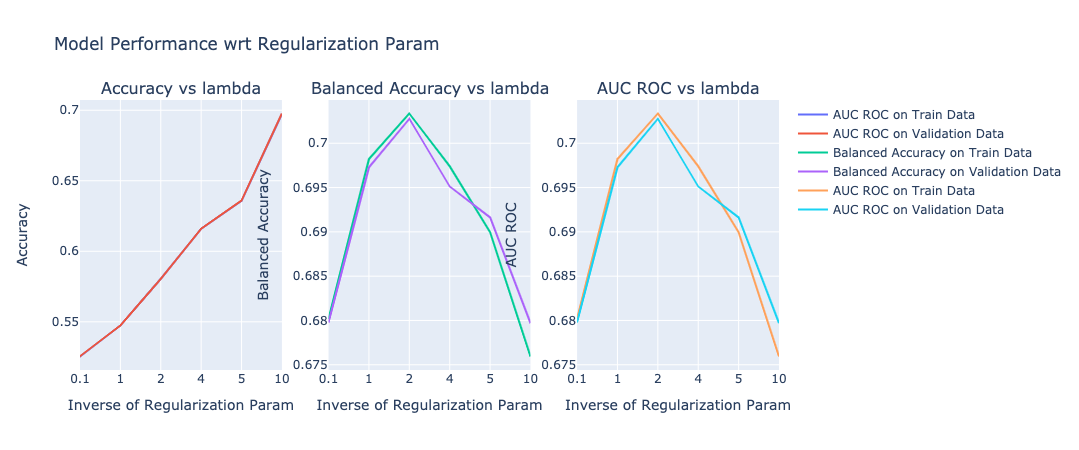

In [38]:
fig = make_subplots(rows=1, cols=3, subplot_titles=("Accuracy vs lambda", "Balanced Accuracy vs lambda", "AUC ROC vs lambda"))
# accuracy
fig.add_trace(go.Scatter(x=C, y=gs.cv_results_['mean_train_Accuracy'], mode='lines', name='AUC ROC on Train Data'),
             row=1, col=1)
fig.add_trace(go.Scatter(x=C, y=gs.cv_results_['mean_test_Accuracy'], mode='lines', name='AUC ROC on Validation Data'),
             row=1, col=1)
# f1 score
fig.add_trace(go.Scatter(x=C, y=gs.cv_results_['mean_train_BalancedAccuracy'], mode='lines', name='Balanced Accuracy on Train Data'), 
             row=1, col=2)
fig.add_trace(go.Scatter(x=C, y=gs.cv_results_['mean_test_BalancedAccuracy'], mode='lines', name='Balanced Accuracy on Validation Data'),
             row=1, col=2)
# auc roc
fig.add_trace(go.Scatter(x=C, y=gs.cv_results_['mean_train_AUC'], mode='lines', name='AUC ROC on Train Data'), 
             row=1, col=3)
fig.add_trace(go.Scatter(x=C, y=gs.cv_results_['mean_test_AUC'], mode='lines', name='AUC ROC on Validation Data'),
             row=1, col=3)

# Update xaxis properties
fig.update_xaxes(title_text="Inverse of Regularization Param", row=1, col=1, type='category')
fig.update_xaxes(title_text="Inverse of Regularization Param", row=1, col=2, type='category')
fig.update_xaxes(title_text="Inverse of Regularization Param", row=1, col=3, type='category')
# Update yaxis properties
fig.update_yaxes(title_text="Accuracy", row=1, col=1)
fig.update_yaxes(title_text="Balanced Accuracy", row=1, col=2)
fig.update_yaxes(title_text="AUC ROC",  row=1, col=3)
# update layout
fig.update_layout(title='Model Performance wrt Regularization Param')
fig.show()

********************************************************
Accuracy on Test data  0.9932557597589058
********************************************************
Balanced Accuracy on Test data  0.49997315943296816
********************************************************
AUC ROC on Test data  0.49997315943296816
********************************************************
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    502970
           1       0.00      0.00      0.00      3388

    accuracy                           0.99    506358
   macro avg       0.50      0.50      0.50    506358
weighted avg       0.99      0.99      0.99    506358

********************************************************


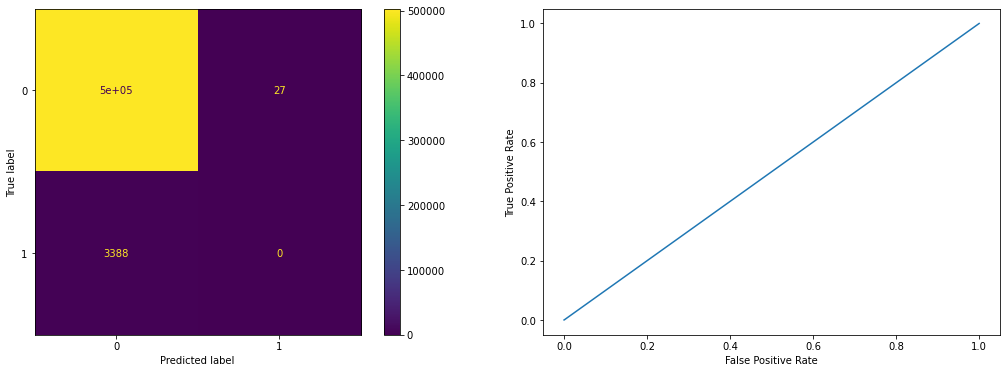

In [37]:
test_nn = scaler.transform(test)
print_classification_report(gs.best_estimator_, test, y_test)

Text(0.5, 1.0, 'Decision boundary of SVC')

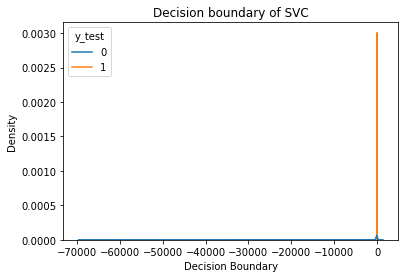

In [32]:
df_prb = pd.DataFrame({"d_func": gs.best_estimator_.decision_function(test_nn), "y_test": y_test})
plt.figure()
sns.kdeplot(df_prb['d_func'], hue=df_prb['y_test'])
plt.xlabel("Decision Boundary")
plt.ylabel("Density")
plt.title("Decision boundary of SVC")

In [33]:
%%time
clf = LinearSVC(penalty='l2', loss='hinge', dual=True, tol=0.001, class_weight="balanced",
          fit_intercept=True, intercept_scaling=1, random_state=12, max_iter=1000, C=0)
clf.fit(train_nn, y_train)

KeyboardInterrupt: 